# SUDOSUDOOHIO SOURCE

https://www.kaggle.com/sudosudoohio/stratified-kfold-xgboost-eda-tutorial-0-281

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import os

In [3]:
os.chdir( r"D:\My Computer\DATA\Porto_Seguros")

# Load, combine, save index, delete excess data from memory
train = pd.read_csv("train.csv",na_values=-1)
test = pd.read_csv("test.csv",na_values=-1)

features = train.drop(['id','target'], axis=1).values
targets = train.target.values

In [4]:
train.isnull().values.any()

True

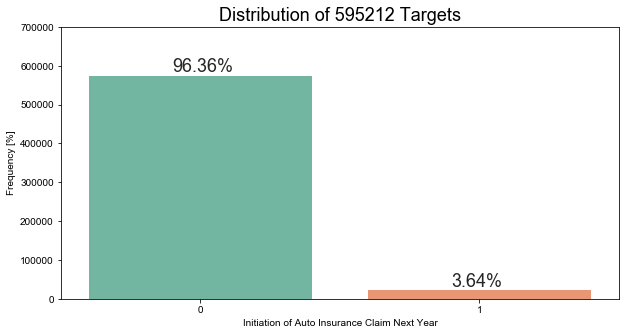

In [5]:
ax = sns.countplot(x = targets ,palette="Set2")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=700000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(targets)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 595212 Targets')
plt.xlabel('Initiation of Auto Insurance Claim Next Year')
plt.ylabel('Frequency [%]')
plt.show()

D:\WindowsApps\Anaconda\envs\tensorflow\lib\site-packages\seaborn\palettes.py:727: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))
D:\WindowsApps\Anaconda\envs\tensorflow\lib\site-packages\seaborn\palettes.py:727: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


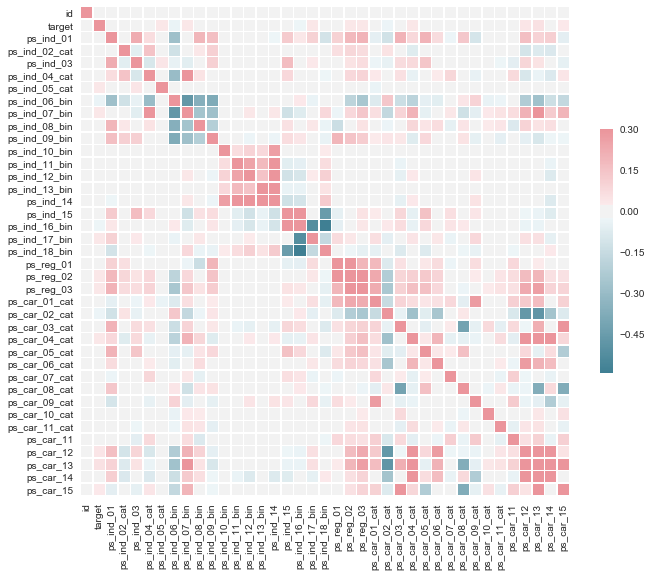

In [16]:
sns.set(style="white")


# Compute the correlation matrix
corr = train.corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [6]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [9]:
unwanted = train.columns[train.columns.str.startswith('ps_calc_')]
train = train.drop(unwanted, axis=1)  
test = test.drop(unwanted, axis=1)

In [10]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)

In [ ]:
# More parameters has to be tuned. Good luck :)
params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

In [12]:
X = train.drop(['id', 'target'], axis=1).values
y = train.target.values
test_id = test.id.values
test = test.drop('id', axis=1)

In [13]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)

In [14]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(test.values)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70,
                    feval=gini_xgb, maximize=True, verbose_eval=100)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    sub['target'] += p_test/kfold

[Fold 1/5]
[0]	train-error:0.036447	valid-error:0.036449	train-gini:0.023568	valid-gini:0.030105
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-error:0.036447	valid-error:0.036449	train-gini:0.321717	valid-gini:0.263208
[200]	train-error:0.036443	valid-error:0.036449	train-gini:0.363434	valid-gini:0.272687
[300]	train-error:0.03643	valid-error:0.036449	train-gini:0.39765	valid-gini:0.278288
[400]	train-error:0.036424	valid-error:0.036457	train-gini:0.426342	valid-gini:0.280264
[500]	train-error:0.036418	valid-error:0.036449	train-gini:0.448977	valid-gini:0.279886
Stopping. Best iteration:
[438]	train-error:0.036424	valid-error:0.036457	train-gini:0.435328	valid-gini:0.280578

[Fold 1/5 Prediciton:]
[Fold 2/5]
[0]	train-error:0.036447	valid-error:0.036449	train-gini:0.023179	valid-gini:0.036347
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

In [15]:
sub.to_csv('Porto/StratifiedKFold.csv', index=False)

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Evalaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [ ]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(100, 500),
    "max_depth": st.randint(2, 8),
    "learning_rate": [0.01],
    #'max_features':'sqrt',
    #"learning_rate": st.uniform(0.001, 0.1),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 3),
    #'reg_alpha': from_zero_positive,
    #"min_child_weight": from_zero_positive,
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

xgbreg = XGBClassifier(objective= 'binary:logistic', feval=gini_xgb,
                       nthreads=2)

grid = RandomizedSearchCV(xgbreg, params, n_jobs=1, verbose=1,
                          n_iter=n_iter)  
grid.fit(X_train,y_train, verbose=False)
save(grid, "Sci_kit XGB")